In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import sys
sys.path.append("../..")  # Add repository root to Python path

import torch
import torch.nn as nn
from convlstm.model import ConvLSTM, ConvLSTMCell

In [2]:
dataset = xr.open_dataset("../../combined_data/jan2025.nc")
input_vars = ["d2m", "u10", "v10", "tp", "lai_hv", "lai_lv"]
output_vars = ["frp"]
dataset[input_vars]

<xarray.Dataset> Size: 2MB
Dimensions:     (valid_time: 744, latitude: 8, longitude: 16)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2025-01-01 ... 2025-01-31T23:...
  * latitude    (latitude) float64 64B 34.75 34.65 34.55 ... 34.25 34.15 34.05
  * longitude   (longitude) float64 128B -119.0 -118.9 -118.8 ... -117.6 -117.5
    expver      (valid_time) <U4 12kB ...
Data variables:
    d2m         (valid_time, latitude, longitude) float32 381kB ...
    u10         (valid_time, latitude, longitude) float32 381kB ...
    v10         (valid_time, latitude, longitude) float32 381kB ...
    tp          (valid_time, latitude, longitude) float32 381kB ...
    lai_hv      (valid_time, latitude, longitude) float32 381kB ...
    lai_lv      (valid_time, latitude, longitude) float32 381kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-18T21:20 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
X = torch.tensor(np.stack([dataset[input_var].values for input_var in input_vars], axis=-1), dtype=torch.float32)
print(X.shape)

y = torch.tensor(dataset['frp'].values, dtype=torch.float32)
print(y.shape)

torch.Size([744, 8, 16, 6])
torch.Size([744, 8, 16])


In [4]:
# Check for NaN values in the input data
print(f"Number of NaN values in X: {torch.isnan(X).sum().item()}")

# Function to interpolate NaN values with the average of neighboring values
def interpolate_nans(tensor):
    # Create a copy of the tensor to avoid modifying the original
    interpolated = tensor.clone()
    
    # Get the dimensions
    time_steps, height, width, features = tensor.shape
    
    # Iterate through each time step
    for t in range(time_steps):
        # Iterate through each feature
        for f in range(features):
            # Find positions with NaN values
            nan_mask = torch.isnan(tensor[t, :, :, f])
            
            if not torch.any(nan_mask):
                continue  # Skip if no NaNs in this feature at this time step
            
            # For each NaN position, compute the average of non-NaN neighbors
            for h in range(height):
                for w in range(width):
                    if nan_mask[h, w]:
                        # Define neighbor indices (considering boundaries)
                        h_start = max(0, h-1)
                        h_end = min(height, h+2)
                        w_start = max(0, w-1)
                        w_end = min(width, w+2)
                        
                        # Extract the neighborhood
                        neighborhood = tensor[t, h_start:h_end, w_start:w_end, f]
                        
                        # Calculate mean of non-NaN neighbors
                        valid_neighbors = neighborhood[~torch.isnan(neighborhood)]
                        
                        if len(valid_neighbors) > 0:
                            # Replace NaN with mean of valid neighbors
                            interpolated[t, h, w, f] = valid_neighbors.mean()
                        else:
                            # If all neighbors are NaN, use global mean for this feature
                            feature_data = tensor[:, :, :, f]
                            global_mean = feature_data[~torch.isnan(feature_data)].mean()
                            interpolated[t, h, w, f] = global_mean
    
    return interpolated

# Apply the interpolation
X = interpolate_nans(X)

# Verify that all NaN values have been interpolated
print(f"Number of NaN values after interpolation: {torch.isnan(X).sum().item()}")


Number of NaN values in X: 4464
Number of NaN values after interpolation: 0


In [5]:
# Normalize all features in X
# We'll normalize each feature independently across all time steps, locations

# Get the shape of X
time_steps, height, width, features = X.shape

# Create a copy of X to store normalized values
X_normalized = X.clone()

# Normalize each feature
for f in range(features):
    # Extract the feature across all time steps and locations
    feature_data = X[:, :, :, f]
    
    # Calculate mean and standard deviation of non-NaN values
    feature_mean = feature_data.mean()
    feature_std = feature_data.std()
    
    # Normalize the feature (z-score normalization)
    X_normalized[:, :, :, f] = (feature_data - feature_mean) / feature_std
    
    print(f"Feature {f} - Mean: {feature_mean:.4f}, Std: {feature_std:.4f}")

# Replace the original X with the normalized version
X = X_normalized

print(f"Data normalized. New feature ranges:")
for f in range(features):
    feature_min = X[:, :, :, f].min().item()
    feature_max = X[:, :, :, f].max().item()
    print(f"Feature {f} - Min: {feature_min:.4f}, Max: {feature_max:.4f}")


Feature 0 - Mean: 266.8738, Std: 8.2098
Feature 1 - Mean: -0.5615, Std: 1.5268
Feature 2 - Mean: -1.0642, Std: 1.8361
Feature 3 - Mean: 0.0003, Std: 0.0016
Feature 4 - Mean: 3.1635, Std: 1.6111
Feature 5 - Mean: 1.7614, Std: 0.8092
Data normalized. New feature ranges:
Feature 0 - Min: -2.4544, Max: 2.1073
Feature 1 - Min: -5.2942, Max: 5.5459
Feature 2 - Min: -4.7070, Max: 4.0335
Feature 3 - Min: -0.2122, Max: 9.8967
Feature 4 - Min: -1.9636, Max: 1.1238
Feature 5 - Min: -1.5395, Max: 1.2822


In [6]:
# Split the data along the time dimension (first axis)
# Use the last 30% of the time steps for testing
split_idx = int(X.shape[0] * 0.8)  # 70% for training, 30% for testing

# Split the input data
X_train = X[:split_idx]
X_test = X[split_idx:]

# Split the target data
y_train = y[:split_idx]
y_test = y[split_idx:]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")


Training data shape: torch.Size([595, 8, 16, 6])
Testing data shape: torch.Size([149, 8, 16, 6])
Training labels shape: torch.Size([595, 8, 16])
Testing labels shape: torch.Size([149, 8, 16])


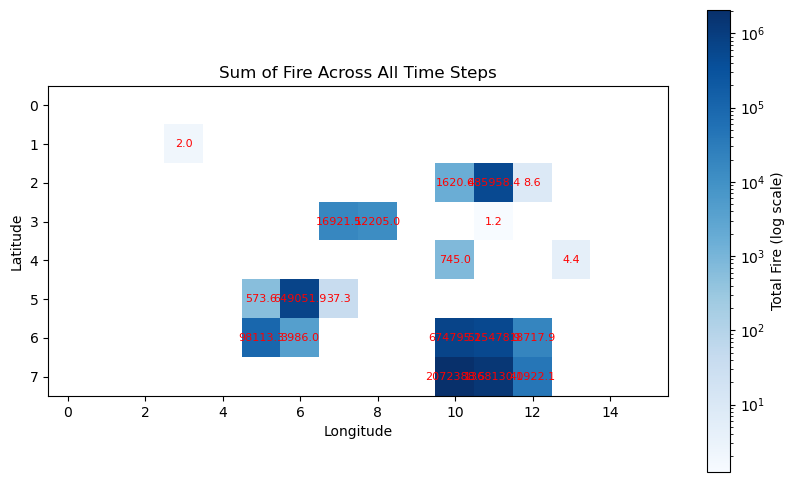

In [8]:
# Sum along the time/batch axis
fire_sum = torch.sum(y_train, dim=0).numpy()
# Visualize the sum of fire across all time steps with a log scale to make any non-zero values visible
plt.figure(figsize=(10, 6))
# Use log normalization with a small epsilon to handle zeros
from matplotlib.colors import LogNorm
plt.imshow(fire_sum, cmap='Blues', 
           norm=LogNorm(vmin=max(0.01, fire_sum[fire_sum > 0].min()), 
                        vmax=fire_sum.max()))
plt.colorbar(label='Total Fire (log scale)')
plt.title('Sum of Fire Across All Time Steps')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# Add text annotations for non-zero values
for i in range(fire_sum.shape[0]):
    for j in range(fire_sum.shape[1]):
        if fire_sum[i, j] > 0:
            plt.text(j, i, f'{fire_sum[i, j]:.1f}', 
                     ha='center', va='center', color='red', fontsize=8)
plt.show()


In [ ]:
# Define the ConvLSTM model
# Reshape the data for ConvLSTM input: [batch_size, seq_len, channels, height, width]
# We'll use a sequence length of 5 to capture temporal patterns

# Define sequence length
seq_length = 5

# Reshape input data for ConvLSTM with temporal sequences
height = X_train.shape[1]  # latitude dimension
width = X_train.shape[2]   # longitude dimension
channels = X_train.shape[3]  # number of input variables

# Create sequences from the time dimension
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        # Extract sequence
        seq = data[i:i+seq_length]
        # Target is the next time step after the sequence
        target = y[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return torch.stack(sequences), torch.stack(targets)

# Create training sequences
X_train_seq, y_train_seq = create_sequences(X_train, seq_length)
# For testing, we'll create sequences in the same way
X_test_seq, y_test_seq = create_sequences(X_test, seq_length)

# Reshape to [batch, seq_len, channels, height, width]
batch_size_train = X_train_seq.shape[0]
batch_size_test = X_test_seq.shape[0]
X_train_reshaped = X_train_seq.reshape(batch_size_train, seq_length, channels, height, width)
X_test_reshaped = X_test_seq.reshape(batch_size_test, seq_length, channels, height, width)

print(f"Training sequences shape: {X_train_reshaped.shape}")
print(f"Testing sequences shape: {X_test_reshaped.shape}")

# Define model parameters
input_dim = channels
hidden_dim = 16
kernel_size = (3, 3)
num_layers = 2
batch_first = True
bias = True
return_all_layers = False
learning_rate = 0.01

# Create the model
model = ConvLSTM(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    kernel_size=kernel_size,
    num_layers=num_layers,
    batch_first=batch_first,
    bias=bias,
    return_all_layers=return_all_layers
)
# Add a final convolutional layer to reduce to a single output channel
final_conv = nn.Conv2d(hidden_dim, 1, kernel_size=1)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(list(model.parameters()) + list(final_conv.parameters()), lr=learning_rate)

# Training parameters
num_epochs = 200
batch_size = 4

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Simple batch training (could be improved with DataLoader)
    for i in range(0, batch_size_train, batch_size):
        if i + batch_size > batch_size_train:
            break
            
        # Get batch
        inputs = X_train_reshaped[i:i+batch_size]
        targets = y_train_seq[i:i+batch_size]
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        layer_output, last_state = model(inputs)
        # Take the output from the last layer
        h_out = last_state[0][0]  # [batch, hidden_dim, height, width]
        
        # Apply final convolution to get predictions
        outputs = final_conv(h_out)  # [batch, 1, height, width]
        outputs = outputs.squeeze(1)  # Remove channel dimension
        
        # Calculate loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / batch_size_train
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


Training sequences shape: torch.Size([590, 5, 6, 8, 16])
Testing sequences shape: torch.Size([144, 5, 6, 8, 16])
Epoch 5/200, Loss: 4532218.9843
Epoch 10/200, Loss: 4530850.3876
Epoch 15/200, Loss: 4527235.4571
Epoch 20/200, Loss: 4521899.3596
Epoch 25/200, Loss: 4514260.1455
Epoch 30/200, Loss: 4508892.2944
Epoch 35/200, Loss: 4504315.2532
Epoch 40/200, Loss: 4497594.5858
Epoch 45/200, Loss: 4492108.6817
Epoch 50/200, Loss: 4486626.3273
Epoch 55/200, Loss: 4481018.2967


Test MSE: 939.4182
Test R²: 0.0000
[]
Using sample time index: 0


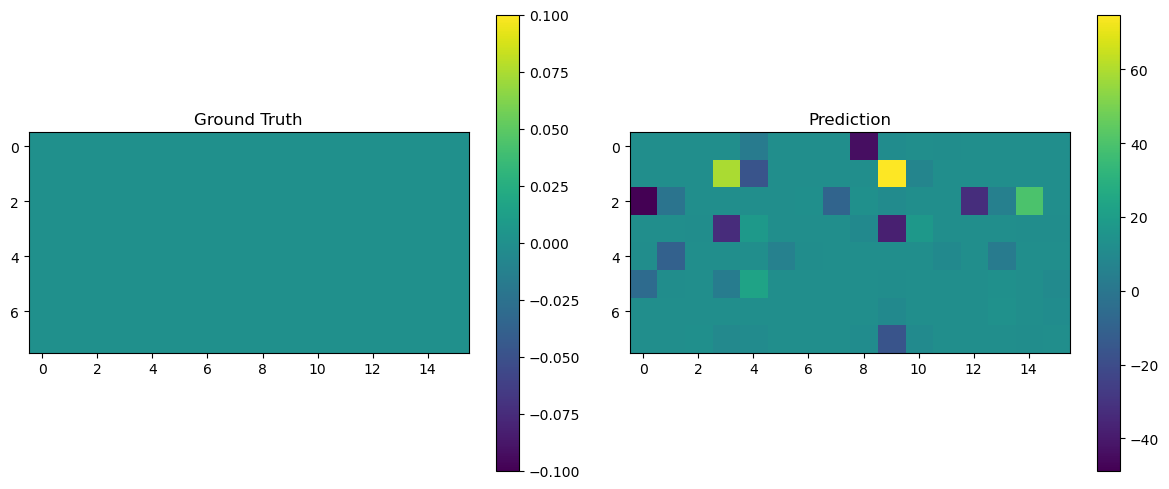

In [15]:
# Evaluation
model.eval()
with torch.no_grad():
    # Process the entire sequence
    layer_output, last_state = model(X_test_reshaped)
    h_out = last_state[0][0]  # Get the hidden state from the last time step
    predictions = final_conv(h_out).squeeze(1)
    
    # Calculate metrics on the sequence predictions
    mse = mean_squared_error(y_test.numpy().flatten(), predictions.numpy().flatten())
    r2 = r2_score(y_test.numpy().flatten(), predictions.numpy().flatten())
    
    print(f'Test MSE: {mse:.4f}')
    print(f'Test R²: {r2:.4f}')

# Find a sample time where ground truth is not all zeros
non_zero_samples = []
for i in range(len(y_test)):
    if np.sum(y_test[i].numpy()) > 0:
        non_zero_samples.append(i)

print(f"Non-zero samples indices: {non_zero_samples}")

sample_time = non_zero_samples[0] if non_zero_samples else 0
print(f"Using sample time index: {sample_time}")

# Visualize results
plt.figure(figsize=(12, 5))

# Plot a sample prediction vs ground truth for a specific time
plt.subplot(1, 2, 1)
plt.imshow(y_test[sample_time].numpy())
plt.colorbar()
plt.title('Ground Truth')

plt.subplot(1, 2, 2)
plt.imshow(predictions[sample_time].numpy())
plt.colorbar()
plt.title('Prediction')

plt.tight_layout()
plt.show()

# Visualize sequence predictions over time if we have multiple non-zero samples
if len(non_zero_samples) > 1:
    plt.figure(figsize=(15, 8))
    
    # Select up to 4 non-zero samples to visualize
    samples_to_show = min(4, len(non_zero_samples))
    for i in range(samples_to_show):
        idx = non_zero_samples[i]
        
        plt.subplot(2, samples_to_show, i+1)
        plt.imshow(y_test[idx].numpy())
        plt.colorbar()
        plt.title(f'Ground Truth (t={idx})')
        
        plt.subplot(2, samples_to_show, i+samples_to_show+1)
        plt.imshow(predictions[idx].numpy())
        plt.colorbar()
        plt.title(f'Prediction (t={idx})')
    
    plt.tight_layout()
    plt.show()
